# Importing relevant libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import os
from datetime import datetime

# Download and Import Dataset

### Run the first 2 cells if running on Colab

In [2]:
# !pip install kaggle

# # Assuming you have your kaggle.json in your Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
# !mkdir ~/.kaggle
# !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# # Download the dataset
# !kaggle datasets download -d shayanfazeli/heartbeat
# !unzip heartbeat.zip

In [3]:
# Download the dataset
# !kaggle datasets download -d sadmansakib7/ecg-arrhythmia-classification-dataset
# !unzip ecg-arrhythmia-classification-dataset.zip

In [4]:
import pandas as pd

mitbih_train = pd.read_csv('mitbih_train.csv', header=None) # 80%
mitbih_test = pd.read_csv('mitbih_test.csv', header=None)   # 20%

In [5]:
print(mitbih_train.shape)
print(mitbih_test.shape)

(87554, 188)
(21892, 188)


# Preprocessing Data

In [ ]:
class ECGDataProcessor:
    """
    Class to handle ECG data preprocessing for multiple datasets
    """
    def __init__(self, mitbih_train_path, mitbih_test_path, incart_path):
        self.mitbih_train_path = mitbih_train_path
        self.mitbih_test_path = mitbih_test_path
        self.incart_path = incart_path
        self.scaler = StandardScaler()

    def load_and_preprocess_mitbih(self):
        """
        Load and preprocess MIT-BIH test dataset
        """
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        return X_train, y_train,X_test, y_test

    def _print_class_distribution(self, dataset_name, y):
        """
        Print class distribution for a dataset
        """
        print(f"\nClass distribution in {dataset_name} dataset:")
        classes = np.unique(y)
        for class_id in classes:
            count = np.sum(y == class_id)
            percentage = (count / len(y)) * 100
            print(f"Class {class_id}: {count} samples ({percentage:.2f}%)")

    def preprocess_mitbih_data(self):
        """
        Load and preprocess MIT-BIH test dataset
        """
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train,
            test_size=0.1,
            random_state=42,
            stratify=y_train # added stratify to our split to keep class distribution
        )

        # Reshape for RNN input (batch_size, sequence_length, input_size)
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        return X_train, X_val, X_test, y_train, y_val, y_test

In [7]:
def analyze_dataset(file_path, name):
    """
    Analyze a dataset file and print information about its structure
    """
    print(f"\nAnalyzing {name} dataset...")
    df = pd.read_csv(file_path, header=None, nrows=5)
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nColumn types:")
    print(df.dtypes)
    print("\nMissing values:")
    print(df.isnull().sum())

In [8]:
# Set file paths
incart_path = 'INCART 2-lead Arrhythmia Database.csv'
mitbih_train_path = 'mitbih_train.csv'
mitbih_test_path = 'mitbih_test.csv'

# Create processor instance
processor = ECGDataProcessor(mitbih_train_path, mitbih_test_path, incart_path)

# Load and preprocess data
X_train, X_val, X_test, y_train, y_val, y_test = processor.preprocess_mitbih_data()

# Print final dataset sizes
print("\nFinal dataset sizes:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Loading MIT-BIH dataset...
MIT-BIH dataset shape: (87554, 187)

Class distribution in MIT-BIH dataset:
Class 0.0: 72471 samples (82.77%)
Class 1.0: 2223 samples (2.54%)
Class 2.0: 5788 samples (6.61%)
Class 3.0: 641 samples (0.73%)
Class 4.0: 6431 samples (7.35%)

Final dataset sizes:
Training set: (78798, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


In [9]:
class ECGDataset(Dataset):
    """
    Custom Dataset class for ECG data
    """
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=32):
    """
    Create train, validation, and test data loaders
    """
    # Create datasets
    train_dataset = ECGDataset(X_train, y_train)
    val_dataset = ECGDataset(X_val, y_val)
    test_dataset = ECGDataset(X_test, y_test)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader

def plot_sample_signals(X, y, dataset_name, num_samples=3):
    """
    Plot sample ECG signals from each class
    """
    classes = np.unique(y)
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 3*len(classes)))

    for i, class_id in enumerate(classes):
        # Get indices for current class
        class_indices = np.where(y == class_id)[0]
        # Randomly select samples
        sample_indices = np.random.choice(class_indices,
                                        min(num_samples, len(class_indices)),
                                        replace=False)

        for j, idx in enumerate(sample_indices):
            signal = X[idx].reshape(-1) if len(X[idx].shape) > 1 else X[idx]
            axes[i, j].plot(signal)
            axes[i, j].set_title(f'Class {class_id}')
            axes[i, j].set_xticks([])
            if j == 0:
                axes[i, j].set_ylabel('Amplitude')

    plt.suptitle(f'Sample ECG Signals from {dataset_name} Dataset')
    plt.tight_layout()
    plt.show()


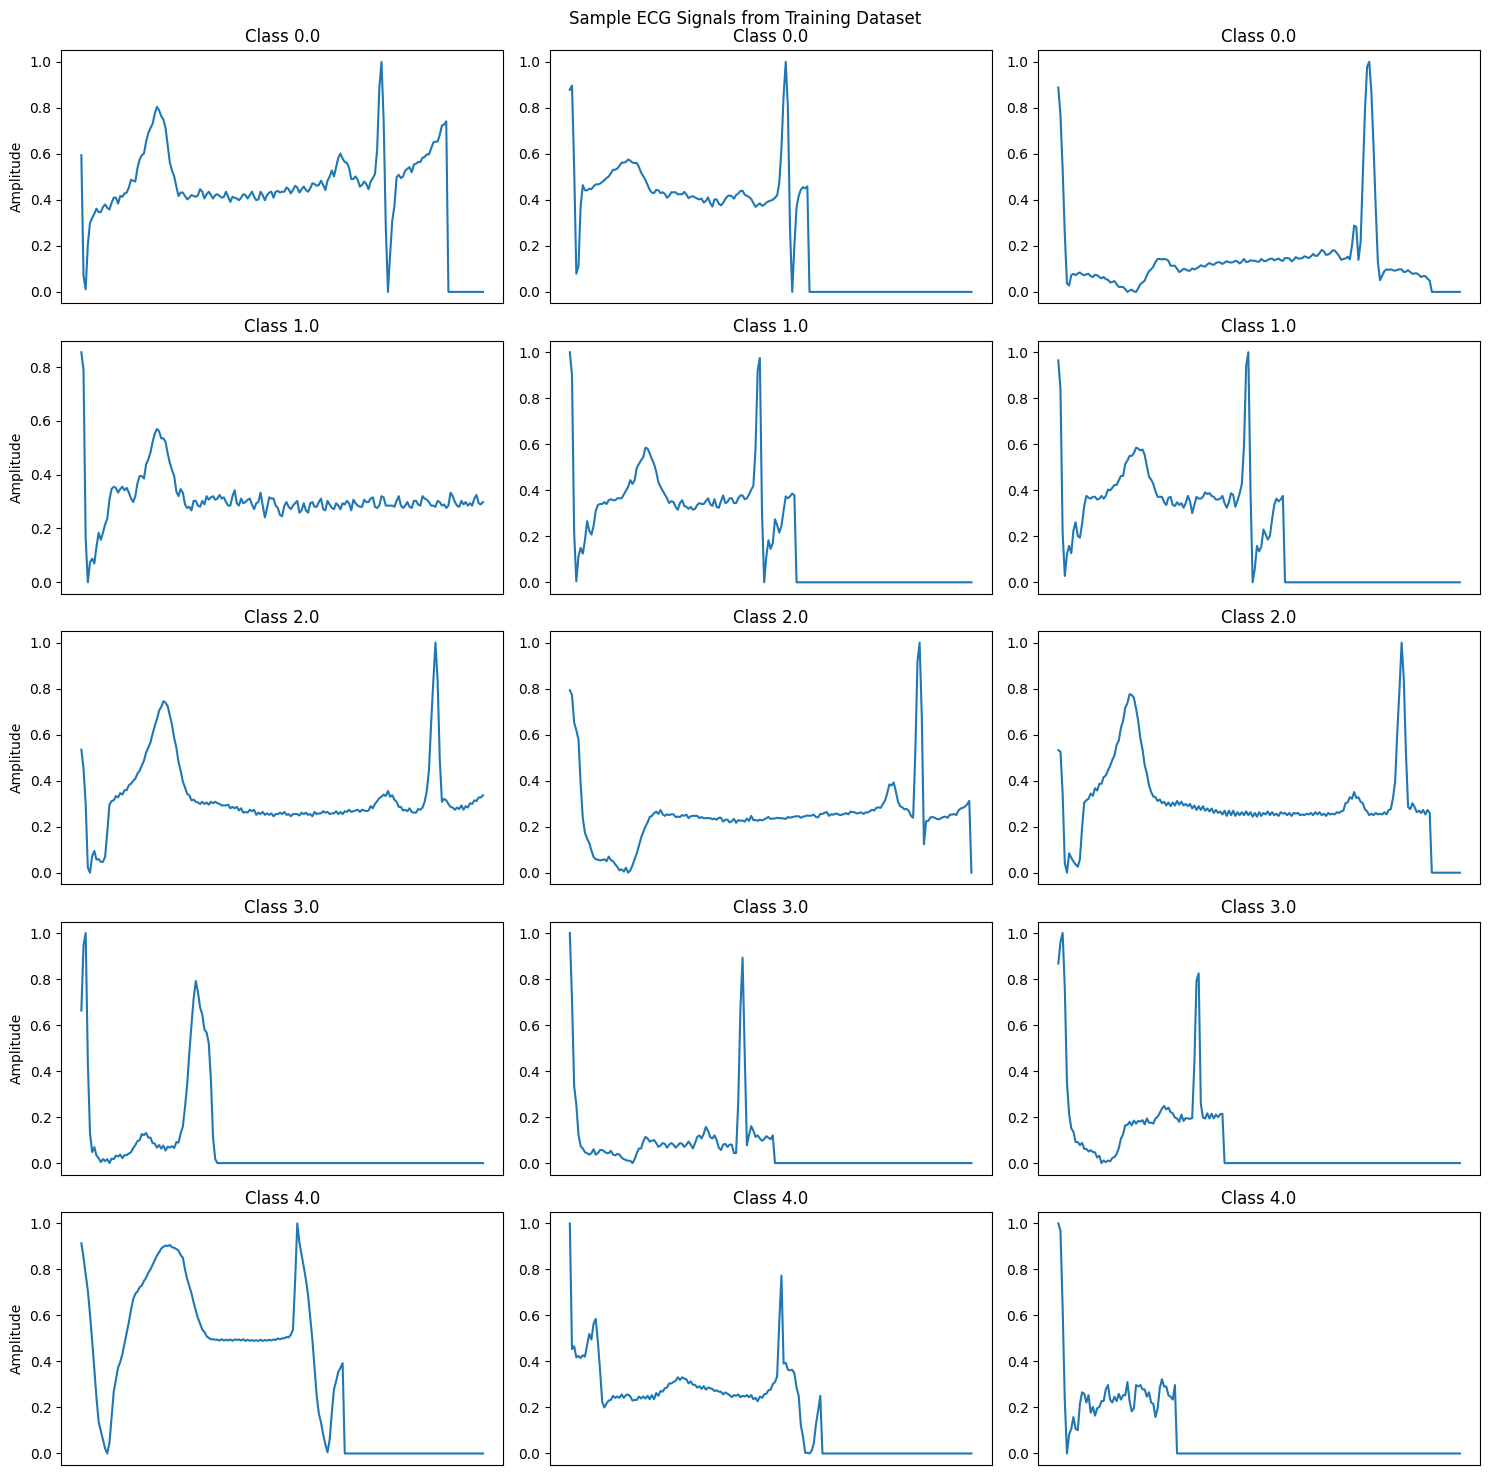


Final dataset sizes:
Training set: (78798, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


In [10]:
 # Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    X_train, X_val, X_test, y_train, y_val, y_test
)

# Plot sample signals from each dataset
plot_sample_signals(X_train, y_train, "Training")

# Print final dataset sizes
print("\nFinal dataset sizes:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# HYBRID MODEL 1

## model architecture

In [11]:
class ImprovedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.3):
        super(ImprovedResidualBlock, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout1d(dropout_rate),
            nn.Conv1d(out_channels, out_channels, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(out_channels)
        )
        
        self.skip_connection = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1),
            nn.BatchNorm1d(out_channels)
        ) if in_channels != out_channels else nn.Identity()
        
        self.dropout = nn.Dropout1d(dropout_rate)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        residual = self.skip_connection(x)
        x = self.conv_block(x)
        x = self.dropout(x + residual)
        x = self.relu(x)
        return x

In [ ]:
class ECG_CNN_RNN(nn.Module):
    """
    ECG_CNN_RNN
    -----------
    Hierarchical ECG classifier combining convolutional feature extraction with
    multi-scale temporal modeling and multi-head attention.

    High-level flow:
    1. CNN Backbone: 1D conv + residual blocks extract local waveform features.
    2. Short-term RNN: bidirectional LSTM over CNN features to capture local temporal patterns.
    3. Long-term RNN: bidirectional LSTM over short-term outputs to capture longer-range dependencies.
    4. Gated Fusion: learn per-timestep blending between short-term and long-term streams.
    5. Multi-head Attention: several independent attention scorers produce per-head contexts.
    6. Context Refinement RNN: an RNN over the stacked head contexts to model inter-head interactions.
    7. Classification Head: LayerNorm + MLP to produce final logits.
    """
    def __init__(self, input_channels=1, sequence_length=187, hidden_size=128, num_heads=4, num_classes=5, dropout=0.3):
        super(ECG_CNN_RNN, self).__init__()

        # --- CNN Backbone ---
        self.conv1 = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=15, padding=7),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.res_block1 = ImprovedResidualBlock(32, 64, dropout_rate=dropout)
        self.res_block2 = ImprovedResidualBlock(64, 128, dropout_rate=dropout)
        self.res_block3 = ImprovedResidualBlock(128, 256, dropout_rate=dropout)

        # --- Short-term RNN ---
        self.short_rnn = nn.LSTM(
            input_size=256,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # --- Long-term RNN ---
        self.long_rnn = nn.LSTM(
            input_size=hidden_size * 2,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # --- Gated Fusion ---
        self.gate = nn.Sequential(
            nn.Linear(hidden_size * 4, hidden_size * 2),
            nn.Sigmoid()
        )

        # --- Multi-head Attention ---
        self.attn_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size * 2, hidden_size),
                nn.Tanh(),
                nn.Linear(hidden_size, 1)
            ) for _ in range(num_heads)
        ])

        # --- Context Refinement RNN ---
        self.context_rnn = nn.LSTM(
            input_size=hidden_size * 2,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # --- Classification Head ---
        self.fc = nn.Sequential(
            nn.LayerNorm(hidden_size * 2),
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )

        # Calculate the size of flattened features
        self._feature_size = self._get_feature_size(input_channels, sequence_length)

    def _get_feature_size(self, input_channels, sequence_length):
        """Calculate the size of flattened features after convolutions"""
        # Create a dummy tensor to forward through the network
        x = torch.randn(1, input_channels, sequence_length)
        x = self.conv1(x)
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        
        # Return the flattened size
        return x.view(1, -1).size(1)

    def forward(self, x):
        # x: (batch, seq_len, channels) → (batch, channels, seq_len)
        x = x.transpose(1, 2)

        # --- CNN Feature Extraction ---
        x = self.conv1(x)
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)

        # --- Prepare for RNN: (batch, channels, seq_len) → (batch, seq_len, channels) ---
        x = x.transpose(1, 2)

        # --- Short-term RNN ---
        short_out, _ = self.short_rnn(x)

        # --- Long-term RNN ---
        long_out, _ = self.long_rnn(short_out)

        # --- Gated Fusion ---
        combined = torch.cat([short_out, long_out], dim=-1)
        gate = self.gate(combined)
        fused = gate * short_out + (1 - gate) * long_out

        # --- Multi-head Attention ---
        attn_outputs = []
        for head in self.attn_heads:
            weights = head(fused)               # (batch, seq_len, 1)
            weights = F.softmax(weights, dim=1)
            context = torch.sum(weights * fused, dim=1)  # (batch, 2H)
            attn_outputs.append(context)

        # --- Stack and Refine ---
        multihead_context = torch.stack(attn_outputs, dim=1)  # (batch, heads, 2H)
        refined, _ = self.context_rnn(multihead_context)      # (batch, heads, 2H)
        refined = torch.mean(refined, dim=1)                  # (batch, 2H)

        # --- Classification ---
        out = self.fc(refined)
        return out

## training loop

In [13]:
def get_training_config():
    """
    Returns improved training configuration for both RNN and CNN models
    """
    config = {
        'RNN': {
            'model_params': {
                'input_size': 1,
                'hidden_size': 128,
                'num_layers': 2,
                'num_classes': 5,
                'dropout': 0.3,
            },
            'training_params': {
                'initial_lr': 1e-4,
                'max_lr': 3e-3,
                'batch_size': 64,
                'num_epochs': 100,
                'warmup_epochs': 5,
                'label_smoothing': 0.1,
                'weight_decay': 1e-4,
                'gradient_clip_val': 0.5,
            }
        },
        'CNN': {
            'model_params': {
                'input_channels': 1,
                'sequence_length': 187,
                'num_classes': 5,
            },
            'training_params': {
                'initial_lr': 1e-4,
                'max_lr': 3e-3,
                'batch_size': 64,
                'num_epochs': 100,
                'warmup_epochs': 5,
                'label_smoothing': 0.1,
                'weight_decay': 1e-4,
                'gradient_clip_val': 0.5,
            }
        },
        'CNN-RNN': {
            'model_params': {
                'input_channels': 1,
                'sequence_length': 187,
                'hidden_size': 128,
                'num_heads': 4,
                'num_classes': 5,
                'dropout': 0.3
            },
            'training_params': {
                'initial_lr': 1e-4,
                'max_lr': 3e-3,
                'batch_size': 64,
                'num_epochs': 100,
                'warmup_epochs': 5,
                'label_smoothing': 0.1,
                'weight_decay': 1e-4,
                'gradient_clip_val': 0.5,
            }            
        }
    }
    return config

In [14]:
class CustomLRScheduler:
    def __init__(self, optimizer, initial_lr, max_lr, warmup_epochs, total_epochs):
        self.optimizer = optimizer
        self.initial_lr = initial_lr
        self.max_lr = max_lr
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.current_epoch = 0

    def step(self):
        self.current_epoch += 1
        if self.current_epoch <= self.warmup_epochs:
            # Linear warmup
            lr = self.initial_lr + (self.max_lr - self.initial_lr) * (self.current_epoch / self.warmup_epochs)
        else:
            # Cosine annealing
            progress = (self.current_epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)
            lr = self.initial_lr + 0.5 * (self.max_lr - self.initial_lr) * (1 + np.cos(progress * np.pi))

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

        return lr

In [15]:
class SmoothCrossEntropyLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(SmoothCrossEntropyLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        n_classes = pred.size(1)
        target_one_hot = torch.zeros_like(pred).scatter(1, target.unsqueeze(1), 1)
        smoothed_target = target_one_hot * (1 - self.smoothing) + self.smoothing / n_classes
        return torch.mean(torch.sum(-smoothed_target * torch.log_softmax(pred, dim=1), dim=1))

In [16]:
class ModelTrainer:
    def __init__(self, model, model_name, device, criterion, config):
        self.model = model.to(device)
        self.model_name = model_name
        self.device = device
        self.criterion = criterion
        self.config = config

        # Initialize optimizer with weight decay
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=config['initial_lr'],
            weight_decay=config['weight_decay']
        )

        # Initialize learning rate scheduler
        self.scheduler = CustomLRScheduler(
            self.optimizer,
            config['initial_lr'],
            config['max_lr'],
            config['warmup_epochs'],
            config['num_epochs']
        )

        # Initialize tracking metrics
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.best_val_loss = float('inf')

        # Create directory for saving models
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        self.save_dir = os.path.join('models', f"{model_name}_{timestamp}")
        os.makedirs(self.save_dir, exist_ok=True)

    def train_epoch(self, train_loader):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_X, batch_y in tqdm(train_loader, desc='Training'):
            batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

            self.optimizer.zero_grad()

            # Handle different model outputs robustly (model may return logits or (logits, extra))
            result = self.model(batch_X)
            outputs = result[0] if isinstance(result, (tuple, list)) else result

            loss = self.criterion(outputs, batch_y)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            self.optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

        epoch_loss = total_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        return epoch_loss, epoch_acc

    def validate(self, val_loader):
        """Validate the model"""
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

                # Handle different model outputs robustly (model may return logits or (logits, extra))
                result = self.model(batch_X)
                outputs = result[0] if isinstance(result, (tuple, list)) else result

                loss = self.criterion(outputs, batch_y)
                total_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

        epoch_loss = total_loss / len(val_loader)
        epoch_acc = 100 * correct / total
        return epoch_loss, epoch_acc

    def train(self, train_loader, val_loader, num_epochs):
        """Complete training process"""
        print(f"\nStarting training for {self.model_name}...")

        for epoch in range(num_epochs):
            # Training phase
            train_loss, train_acc = self.train_epoch(train_loader)

            # Validation phase
            val_loss, val_acc = self.validate(val_loader)

            # Update learning rate
            self.scheduler.step()  # Removed val_loss parameter
            current_lr = self.optimizer.param_groups[0]['lr']

            # Save metrics
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)

            # Print epoch results
            print(f'\nEpoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print(f'Learning Rate: {current_lr:.6f}')

            # Save best model
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.save_model('best_model.pth')
                print(f'New best model saved! (Val Loss: {val_loss:.4f})')

        # Save final model
        self.save_model('rnn_final_model.pth')

    def save_model(self, filename):
        """Save model checkpoint"""
        path = os.path.join(self.save_dir, filename)
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_accuracies': self.train_accuracies,
            'val_accuracies': self.val_accuracies,
            'config': self.config
        }, path)

    def plot_training_history(self):
        """Plot training metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Plot losses
        ax1.plot(self.train_losses, label='Training Loss')
        ax1.plot(self.val_losses, label='Validation Loss')
        ax1.set_title(f'{self.model_name} - Training History (Loss)')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()

        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Training Accuracy')
        ax2.plot(self.val_accuracies, label='Validation Accuracy')
        ax2.set_title(f'{self.model_name} - Training History (Accuracy)')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'training_history.png'))
        plt.show()

    def evaluate(self, test_loader):
        """Evaluate model on test set"""
        self.model.eval()
        predictions = []
        true_labels = []

        with torch.no_grad():
            for batch_X, batch_y in tqdm(test_loader, desc='Testing'):
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

                # Handle different model outputs robustly (model may return logits or (logits, extra))
                result = self.model(batch_X)
                outputs = result[0] if isinstance(result, (tuple, list)) else result

                _, predicted = torch.max(outputs.data, 1)
                predictions.extend(predicted.cpu().numpy())
                true_labels.extend(batch_y.cpu().numpy())

        # Print classification report
        print(f"\nClassification Report ({self.model_name}):")
        print(classification_report(true_labels, predictions))

        # Plot confusion matrix
        cm = confusion_matrix(true_labels, predictions)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix ({self.model_name})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(os.path.join(self.save_dir, 'confusion_matrix.png'))
        plt.show()

In [17]:
def train_rnn_model(X_train, X_val, X_test, y_train, y_val, y_test):
    """Train both RNN and CNN models"""
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Get configurations
    config = get_training_config()

    # Create data loaders
    train_dataset = ECGDataset(X_train, y_train)
    val_dataset = ECGDataset(X_val, y_val)
    test_dataset = ECGDataset(X_test, y_test)

    batch_size = config['CNN-RNN']['training_params']['batch_size']
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Initialize models
    rnn_model = ECG_CNN_RNN(**config['CNN-RNN']['model_params'])

    # Initialize criterion with label smoothing
    rnn_criterion = SmoothCrossEntropyLoss(smoothing=config['CNN-RNN']['training_params']['label_smoothing'])

    # Train RNN
    rnn_trainer = ModelTrainer(
        model=rnn_model,
        model_name='CNN-RNN',
        device=device,
        criterion=rnn_criterion,
        config=config['CNN-RNN']['training_params']
    )
    rnn_trainer.train(
        train_loader,
        val_loader,
        config['CNN-RNN']['training_params']['num_epochs']
    )
    rnn_trainer.plot_training_history()
    rnn_trainer.evaluate(test_loader)

    return rnn_trainer

In [18]:
 # Update configuration based on actual data
config = get_training_config()
num_classes = len(np.unique(y_train))
sequence_length = X_train.shape[1]

# Update both model configurations
config['RNN']['model_params']['num_classes'] = num_classes
config['CNN']['model_params']['num_classes'] = num_classes
config['CNN']['model_params']['sequence_length'] = sequence_length

print("\nUpdated configuration:")
print(f"Number of classes: {num_classes}")
print(f"Sequence length: {sequence_length}")


Updated configuration:
Number of classes: 5
Sequence length: 187


In [19]:
model = ECG_CNN_RNN(
    input_channels=config['CNN-RNN']['model_params']['input_channels'],
    sequence_length=config['CNN-RNN']['model_params']['sequence_length'],
    hidden_size=config['CNN-RNN']['model_params']['hidden_size'],
    num_heads=config['CNN-RNN']['model_params']['num_heads'],
    num_classes=config['CNN-RNN']['model_params']['num_classes'],
    dropout=config['CNN-RNN']['model_params']['dropout']
)

Using device: cuda

Starting training for CNN-RNN...


Training: 100%|██████████| 1232/1232 [00:24<00:00, 50.97it/s]



Epoch [1/100]
Train Loss: 0.6527, Train Acc: 89.67%
Val Loss: 0.5377, Val Acc: 94.55%
Learning Rate: 0.000680
New best model saved! (Val Loss: 0.5377)


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.87it/s]



Epoch [2/100]
Train Loss: 0.5452, Train Acc: 94.20%
Val Loss: 0.4850, Val Acc: 96.15%
Learning Rate: 0.001260
New best model saved! (Val Loss: 0.4850)


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.26it/s]



Epoch [3/100]
Train Loss: 0.5125, Train Acc: 95.46%
Val Loss: 0.4776, Val Acc: 96.37%
Learning Rate: 0.001840
New best model saved! (Val Loss: 0.4776)


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.61it/s]



Epoch [4/100]
Train Loss: 0.5006, Train Acc: 95.91%
Val Loss: 0.4948, Val Acc: 95.83%
Learning Rate: 0.002420


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.66it/s]



Epoch [5/100]
Train Loss: 0.4934, Train Acc: 96.19%
Val Loss: 0.4640, Val Acc: 97.18%
Learning Rate: 0.003000
New best model saved! (Val Loss: 0.4640)


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.39it/s]



Epoch [6/100]
Train Loss: 0.4849, Train Acc: 96.45%
Val Loss: 0.4591, Val Acc: 97.34%
Learning Rate: 0.002999
New best model saved! (Val Loss: 0.4591)


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.82it/s]



Epoch [7/100]
Train Loss: 0.4732, Train Acc: 96.83%
Val Loss: 0.4533, Val Acc: 97.38%
Learning Rate: 0.002997
New best model saved! (Val Loss: 0.4533)


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.22it/s]



Epoch [8/100]
Train Loss: 0.4698, Train Acc: 96.94%
Val Loss: 0.4538, Val Acc: 97.38%
Learning Rate: 0.002993


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.29it/s]



Epoch [9/100]
Train Loss: 0.4620, Train Acc: 97.23%
Val Loss: 0.4492, Val Acc: 97.67%
Learning Rate: 0.002987
New best model saved! (Val Loss: 0.4492)


Training: 100%|██████████| 1232/1232 [00:19<00:00, 62.03it/s]



Epoch [10/100]
Train Loss: 0.4615, Train Acc: 97.19%
Val Loss: 0.4478, Val Acc: 97.64%
Learning Rate: 0.002980
New best model saved! (Val Loss: 0.4478)


Training: 100%|██████████| 1232/1232 [00:20<00:00, 59.98it/s]



Epoch [11/100]
Train Loss: 0.4552, Train Acc: 97.45%
Val Loss: 0.4398, Val Acc: 98.05%
Learning Rate: 0.002972
New best model saved! (Val Loss: 0.4398)


Training: 100%|██████████| 1232/1232 [00:20<00:00, 59.90it/s]



Epoch [12/100]
Train Loss: 0.4533, Train Acc: 97.45%
Val Loss: 0.4495, Val Acc: 97.65%
Learning Rate: 0.002961


Training: 100%|██████████| 1232/1232 [00:20<00:00, 60.84it/s]



Epoch [13/100]
Train Loss: 0.4505, Train Acc: 97.62%
Val Loss: 0.4380, Val Acc: 98.04%
Learning Rate: 0.002950
New best model saved! (Val Loss: 0.4380)


Training: 100%|██████████| 1232/1232 [00:20<00:00, 60.68it/s]



Epoch [14/100]
Train Loss: 0.4484, Train Acc: 97.71%
Val Loss: 0.4387, Val Acc: 98.12%
Learning Rate: 0.002936


Training: 100%|██████████| 1232/1232 [00:20<00:00, 60.88it/s]



Epoch [15/100]
Train Loss: 0.4445, Train Acc: 97.80%
Val Loss: 0.4442, Val Acc: 97.70%
Learning Rate: 0.002921


Training: 100%|██████████| 1232/1232 [00:20<00:00, 61.47it/s]



Epoch [16/100]
Train Loss: 0.4443, Train Acc: 97.78%
Val Loss: 0.4324, Val Acc: 98.13%
Learning Rate: 0.002905
New best model saved! (Val Loss: 0.4324)


Training: 100%|██████████| 1232/1232 [00:19<00:00, 62.44it/s]



Epoch [17/100]
Train Loss: 0.4418, Train Acc: 97.96%
Val Loss: 0.4322, Val Acc: 98.13%
Learning Rate: 0.002887
New best model saved! (Val Loss: 0.4322)


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.16it/s]



Epoch [18/100]
Train Loss: 0.4411, Train Acc: 97.96%
Val Loss: 0.4345, Val Acc: 98.16%
Learning Rate: 0.002868


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.39it/s]



Epoch [19/100]
Train Loss: 0.4398, Train Acc: 97.97%
Val Loss: 0.4293, Val Acc: 98.41%
Learning Rate: 0.002847
New best model saved! (Val Loss: 0.4293)


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.77it/s]



Epoch [20/100]
Train Loss: 0.4391, Train Acc: 98.05%
Val Loss: 0.4320, Val Acc: 98.32%
Learning Rate: 0.002825


Training: 100%|██████████| 1232/1232 [00:18<00:00, 64.88it/s]



Epoch [21/100]
Train Loss: 0.4385, Train Acc: 98.07%
Val Loss: 0.4278, Val Acc: 98.42%
Learning Rate: 0.002802
New best model saved! (Val Loss: 0.4278)


Training: 100%|██████████| 1232/1232 [00:19<00:00, 63.69it/s]



Epoch [22/100]
Train Loss: 0.4376, Train Acc: 98.07%
Val Loss: 0.4352, Val Acc: 98.23%
Learning Rate: 0.002777


Training: 100%|██████████| 1232/1232 [00:19<00:00, 63.85it/s]



Epoch [23/100]
Train Loss: 0.4355, Train Acc: 98.14%
Val Loss: 0.4279, Val Acc: 98.49%
Learning Rate: 0.002751


Training: 100%|██████████| 1232/1232 [00:19<00:00, 63.59it/s]



Epoch [24/100]
Train Loss: 0.4351, Train Acc: 98.17%
Val Loss: 0.4278, Val Acc: 98.46%
Learning Rate: 0.002723
New best model saved! (Val Loss: 0.4278)


Training: 100%|██████████| 1232/1232 [00:19<00:00, 64.25it/s]



Epoch [25/100]
Train Loss: 0.4358, Train Acc: 98.14%
Val Loss: 0.4231, Val Acc: 98.60%
Learning Rate: 0.002694
New best model saved! (Val Loss: 0.4231)


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.26it/s]



Epoch [26/100]
Train Loss: 0.4354, Train Acc: 98.17%
Val Loss: 0.4275, Val Acc: 98.49%
Learning Rate: 0.002664


Training: 100%|██████████| 1232/1232 [00:19<00:00, 62.55it/s]



Epoch [27/100]
Train Loss: 0.4339, Train Acc: 98.20%
Val Loss: 0.4245, Val Acc: 98.58%
Learning Rate: 0.002633


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.08it/s]



Epoch [28/100]
Train Loss: 0.4308, Train Acc: 98.38%
Val Loss: 0.4249, Val Acc: 98.64%
Learning Rate: 0.002600


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.16it/s]



Epoch [29/100]
Train Loss: 0.4307, Train Acc: 98.38%
Val Loss: 0.4213, Val Acc: 98.61%
Learning Rate: 0.002567
New best model saved! (Val Loss: 0.4213)


Training: 100%|██████████| 1232/1232 [00:19<00:00, 64.41it/s]



Epoch [30/100]
Train Loss: 0.4298, Train Acc: 98.40%
Val Loss: 0.4238, Val Acc: 98.55%
Learning Rate: 0.002532


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.84it/s]



Epoch [31/100]
Train Loss: 0.4313, Train Acc: 98.33%
Val Loss: 0.4234, Val Acc: 98.66%
Learning Rate: 0.002496


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.96it/s]



Epoch [32/100]
Train Loss: 0.4283, Train Acc: 98.47%
Val Loss: 0.4237, Val Acc: 98.52%
Learning Rate: 0.002459


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.59it/s]



Epoch [33/100]
Train Loss: 0.4289, Train Acc: 98.43%
Val Loss: 0.4249, Val Acc: 98.46%
Learning Rate: 0.002422


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.09it/s]



Epoch [34/100]
Train Loss: 0.4281, Train Acc: 98.46%
Val Loss: 0.4211, Val Acc: 98.58%
Learning Rate: 0.002383
New best model saved! (Val Loss: 0.4211)


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.86it/s]



Epoch [35/100]
Train Loss: 0.4271, Train Acc: 98.51%
Val Loss: 0.4213, Val Acc: 98.69%
Learning Rate: 0.002343


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.20it/s]



Epoch [36/100]
Train Loss: 0.4267, Train Acc: 98.47%
Val Loss: 0.4204, Val Acc: 98.64%
Learning Rate: 0.002303
New best model saved! (Val Loss: 0.4204)


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.52it/s]



Epoch [37/100]
Train Loss: 0.4255, Train Acc: 98.55%
Val Loss: 0.4227, Val Acc: 98.60%
Learning Rate: 0.002261


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.95it/s]



Epoch [38/100]
Train Loss: 0.4262, Train Acc: 98.51%
Val Loss: 0.4218, Val Acc: 98.74%
Learning Rate: 0.002219


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.62it/s]



Epoch [39/100]
Train Loss: 0.4236, Train Acc: 98.66%
Val Loss: 0.4193, Val Acc: 98.69%
Learning Rate: 0.002176
New best model saved! (Val Loss: 0.4193)


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.68it/s]



Epoch [40/100]
Train Loss: 0.4234, Train Acc: 98.65%
Val Loss: 0.4191, Val Acc: 98.74%
Learning Rate: 0.002132
New best model saved! (Val Loss: 0.4191)


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.58it/s]



Epoch [41/100]
Train Loss: 0.4227, Train Acc: 98.66%
Val Loss: 0.4185, Val Acc: 98.79%
Learning Rate: 0.002088
New best model saved! (Val Loss: 0.4185)


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.72it/s]



Epoch [42/100]
Train Loss: 0.4228, Train Acc: 98.64%
Val Loss: 0.4243, Val Acc: 98.47%
Learning Rate: 0.002043


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.39it/s]



Epoch [43/100]
Train Loss: 0.4233, Train Acc: 98.67%
Val Loss: 0.4208, Val Acc: 98.61%
Learning Rate: 0.001998


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.99it/s]



Epoch [44/100]
Train Loss: 0.4208, Train Acc: 98.76%
Val Loss: 0.4216, Val Acc: 98.76%
Learning Rate: 0.001952


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.53it/s]



Epoch [45/100]
Train Loss: 0.4209, Train Acc: 98.74%
Val Loss: 0.4196, Val Acc: 98.70%
Learning Rate: 0.001906


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.62it/s]



Epoch [46/100]
Train Loss: 0.4195, Train Acc: 98.79%
Val Loss: 0.4171, Val Acc: 98.76%
Learning Rate: 0.001859
New best model saved! (Val Loss: 0.4171)


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.50it/s]



Epoch [47/100]
Train Loss: 0.4179, Train Acc: 98.84%
Val Loss: 0.4167, Val Acc: 98.78%
Learning Rate: 0.001812
New best model saved! (Val Loss: 0.4167)


Training: 100%|██████████| 1232/1232 [00:19<00:00, 63.18it/s]



Epoch [48/100]
Train Loss: 0.4185, Train Acc: 98.83%
Val Loss: 0.4163, Val Acc: 98.81%
Learning Rate: 0.001765
New best model saved! (Val Loss: 0.4163)


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.65it/s]



Epoch [49/100]
Train Loss: 0.4177, Train Acc: 98.88%
Val Loss: 0.4177, Val Acc: 98.81%
Learning Rate: 0.001717


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.88it/s]



Epoch [50/100]
Train Loss: 0.4195, Train Acc: 98.77%
Val Loss: 0.4186, Val Acc: 98.79%
Learning Rate: 0.001670


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.68it/s]



Epoch [51/100]
Train Loss: 0.4176, Train Acc: 98.89%
Val Loss: 0.4165, Val Acc: 98.86%
Learning Rate: 0.001622


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.38it/s]



Epoch [52/100]
Train Loss: 0.4174, Train Acc: 98.91%
Val Loss: 0.4141, Val Acc: 98.87%
Learning Rate: 0.001574
New best model saved! (Val Loss: 0.4141)


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.80it/s]



Epoch [53/100]
Train Loss: 0.4159, Train Acc: 98.96%
Val Loss: 0.4173, Val Acc: 98.81%
Learning Rate: 0.001526


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.84it/s]



Epoch [54/100]
Train Loss: 0.4155, Train Acc: 98.98%
Val Loss: 0.4182, Val Acc: 98.85%
Learning Rate: 0.001478


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.56it/s]



Epoch [55/100]
Train Loss: 0.4145, Train Acc: 99.01%
Val Loss: 0.4161, Val Acc: 98.78%
Learning Rate: 0.001430


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.88it/s]



Epoch [56/100]
Train Loss: 0.4139, Train Acc: 99.05%
Val Loss: 0.4161, Val Acc: 98.90%
Learning Rate: 0.001383


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.65it/s]



Epoch [57/100]
Train Loss: 0.4123, Train Acc: 99.11%
Val Loss: 0.4139, Val Acc: 98.95%
Learning Rate: 0.001335
New best model saved! (Val Loss: 0.4139)


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.80it/s]



Epoch [58/100]
Train Loss: 0.4133, Train Acc: 99.05%
Val Loss: 0.4149, Val Acc: 98.90%
Learning Rate: 0.001288


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.69it/s]



Epoch [59/100]
Train Loss: 0.4124, Train Acc: 99.08%
Val Loss: 0.4141, Val Acc: 98.92%
Learning Rate: 0.001241


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.62it/s]



Epoch [60/100]
Train Loss: 0.4117, Train Acc: 99.12%
Val Loss: 0.4146, Val Acc: 99.03%
Learning Rate: 0.001194


Training: 100%|██████████| 1232/1232 [00:19<00:00, 62.47it/s]



Epoch [61/100]
Train Loss: 0.4108, Train Acc: 99.16%
Val Loss: 0.4124, Val Acc: 98.98%
Learning Rate: 0.001148
New best model saved! (Val Loss: 0.4124)


Training: 100%|██████████| 1232/1232 [00:20<00:00, 60.81it/s]



Epoch [62/100]
Train Loss: 0.4098, Train Acc: 99.20%
Val Loss: 0.4131, Val Acc: 99.11%
Learning Rate: 0.001102


Training: 100%|██████████| 1232/1232 [00:20<00:00, 61.13it/s]



Epoch [63/100]
Train Loss: 0.4096, Train Acc: 99.20%
Val Loss: 0.4145, Val Acc: 98.95%
Learning Rate: 0.001057


Training: 100%|██████████| 1232/1232 [00:19<00:00, 62.51it/s]



Epoch [64/100]
Train Loss: 0.4097, Train Acc: 99.16%
Val Loss: 0.4127, Val Acc: 99.01%
Learning Rate: 0.001012


Training: 100%|██████████| 1232/1232 [00:19<00:00, 62.30it/s]



Epoch [65/100]
Train Loss: 0.4089, Train Acc: 99.24%
Val Loss: 0.4131, Val Acc: 98.98%
Learning Rate: 0.000968


Training: 100%|██████████| 1232/1232 [00:19<00:00, 61.79it/s]



Epoch [66/100]
Train Loss: 0.4085, Train Acc: 99.28%
Val Loss: 0.4130, Val Acc: 99.02%
Learning Rate: 0.000924


Training: 100%|██████████| 1232/1232 [00:19<00:00, 64.35it/s]



Epoch [67/100]
Train Loss: 0.4079, Train Acc: 99.25%
Val Loss: 0.4114, Val Acc: 99.04%
Learning Rate: 0.000881
New best model saved! (Val Loss: 0.4114)


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.28it/s]



Epoch [68/100]
Train Loss: 0.4074, Train Acc: 99.30%
Val Loss: 0.4131, Val Acc: 98.99%
Learning Rate: 0.000839


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.80it/s]



Epoch [69/100]
Train Loss: 0.4076, Train Acc: 99.30%
Val Loss: 0.4134, Val Acc: 98.99%
Learning Rate: 0.000797


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.55it/s]



Epoch [70/100]
Train Loss: 0.4074, Train Acc: 99.29%
Val Loss: 0.4140, Val Acc: 98.96%
Learning Rate: 0.000757


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.46it/s]



Epoch [71/100]
Train Loss: 0.4059, Train Acc: 99.37%
Val Loss: 0.4144, Val Acc: 98.96%
Learning Rate: 0.000717


Training: 100%|██████████| 1232/1232 [00:18<00:00, 66.01it/s]



Epoch [72/100]
Train Loss: 0.4058, Train Acc: 99.37%
Val Loss: 0.4135, Val Acc: 98.98%
Learning Rate: 0.000678


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.72it/s]



Epoch [73/100]
Train Loss: 0.4058, Train Acc: 99.36%
Val Loss: 0.4112, Val Acc: 99.13%
Learning Rate: 0.000641
New best model saved! (Val Loss: 0.4112)


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.46it/s]



Epoch [74/100]
Train Loss: 0.4056, Train Acc: 99.37%
Val Loss: 0.4139, Val Acc: 98.95%
Learning Rate: 0.000604


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.85it/s]



Epoch [75/100]
Train Loss: 0.4040, Train Acc: 99.42%
Val Loss: 0.4116, Val Acc: 99.04%
Learning Rate: 0.000568


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.70it/s]



Epoch [76/100]
Train Loss: 0.4041, Train Acc: 99.42%
Val Loss: 0.4109, Val Acc: 99.04%
Learning Rate: 0.000533
New best model saved! (Val Loss: 0.4109)


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.72it/s]



Epoch [77/100]
Train Loss: 0.4028, Train Acc: 99.48%
Val Loss: 0.4116, Val Acc: 99.09%
Learning Rate: 0.000500


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.63it/s]



Epoch [78/100]
Train Loss: 0.4026, Train Acc: 99.51%
Val Loss: 0.4114, Val Acc: 98.97%
Learning Rate: 0.000467


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.47it/s]



Epoch [79/100]
Train Loss: 0.4025, Train Acc: 99.53%
Val Loss: 0.4125, Val Acc: 99.10%
Learning Rate: 0.000436


Training: 100%|██████████| 1232/1232 [00:18<00:00, 66.02it/s]



Epoch [80/100]
Train Loss: 0.4022, Train Acc: 99.53%
Val Loss: 0.4117, Val Acc: 99.05%
Learning Rate: 0.000406


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.60it/s]



Epoch [81/100]
Train Loss: 0.4020, Train Acc: 99.54%
Val Loss: 0.4104, Val Acc: 99.05%
Learning Rate: 0.000377
New best model saved! (Val Loss: 0.4104)


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.53it/s]



Epoch [82/100]
Train Loss: 0.4019, Train Acc: 99.54%
Val Loss: 0.4115, Val Acc: 99.10%
Learning Rate: 0.000349


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.25it/s]



Epoch [83/100]
Train Loss: 0.4021, Train Acc: 99.53%
Val Loss: 0.4119, Val Acc: 99.09%
Learning Rate: 0.000323


Training: 100%|██████████| 1232/1232 [00:18<00:00, 66.04it/s]



Epoch [84/100]
Train Loss: 0.4013, Train Acc: 99.58%
Val Loss: 0.4121, Val Acc: 99.09%
Learning Rate: 0.000298


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.71it/s]



Epoch [85/100]
Train Loss: 0.4013, Train Acc: 99.58%
Val Loss: 0.4127, Val Acc: 99.09%
Learning Rate: 0.000275


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.82it/s]



Epoch [86/100]
Train Loss: 0.4008, Train Acc: 99.58%
Val Loss: 0.4124, Val Acc: 99.01%
Learning Rate: 0.000253


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.63it/s]



Epoch [87/100]
Train Loss: 0.4010, Train Acc: 99.57%
Val Loss: 0.4129, Val Acc: 99.04%
Learning Rate: 0.000232


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.69it/s]



Epoch [88/100]
Train Loss: 0.4010, Train Acc: 99.58%
Val Loss: 0.4126, Val Acc: 99.04%
Learning Rate: 0.000213


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.77it/s]



Epoch [89/100]
Train Loss: 0.4003, Train Acc: 99.61%
Val Loss: 0.4128, Val Acc: 99.05%
Learning Rate: 0.000195


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.51it/s]



Epoch [90/100]
Train Loss: 0.4003, Train Acc: 99.62%
Val Loss: 0.4122, Val Acc: 99.05%
Learning Rate: 0.000179


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.89it/s]



Epoch [91/100]
Train Loss: 0.4000, Train Acc: 99.61%
Val Loss: 0.4128, Val Acc: 99.06%
Learning Rate: 0.000164


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.18it/s]



Epoch [92/100]
Train Loss: 0.4002, Train Acc: 99.61%
Val Loss: 0.4124, Val Acc: 99.11%
Learning Rate: 0.000150


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.69it/s]



Epoch [93/100]
Train Loss: 0.4002, Train Acc: 99.63%
Val Loss: 0.4118, Val Acc: 99.10%
Learning Rate: 0.000139


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.42it/s]



Epoch [94/100]
Train Loss: 0.3993, Train Acc: 99.65%
Val Loss: 0.4112, Val Acc: 99.12%
Learning Rate: 0.000128


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.88it/s]



Epoch [95/100]
Train Loss: 0.3997, Train Acc: 99.64%
Val Loss: 0.4120, Val Acc: 99.04%
Learning Rate: 0.000120


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.19it/s]



Epoch [96/100]
Train Loss: 0.3995, Train Acc: 99.65%
Val Loss: 0.4122, Val Acc: 99.04%
Learning Rate: 0.000113


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.32it/s]



Epoch [97/100]
Train Loss: 0.3991, Train Acc: 99.68%
Val Loss: 0.4128, Val Acc: 99.01%
Learning Rate: 0.000107


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.74it/s]



Epoch [98/100]
Train Loss: 0.3993, Train Acc: 99.66%
Val Loss: 0.4121, Val Acc: 99.06%
Learning Rate: 0.000103


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.67it/s]



Epoch [99/100]
Train Loss: 0.3992, Train Acc: 99.64%
Val Loss: 0.4116, Val Acc: 99.09%
Learning Rate: 0.000101


Training: 100%|██████████| 1232/1232 [00:18<00:00, 65.44it/s]



Epoch [100/100]
Train Loss: 0.3993, Train Acc: 99.67%
Val Loss: 0.4117, Val Acc: 99.07%
Learning Rate: 0.000100


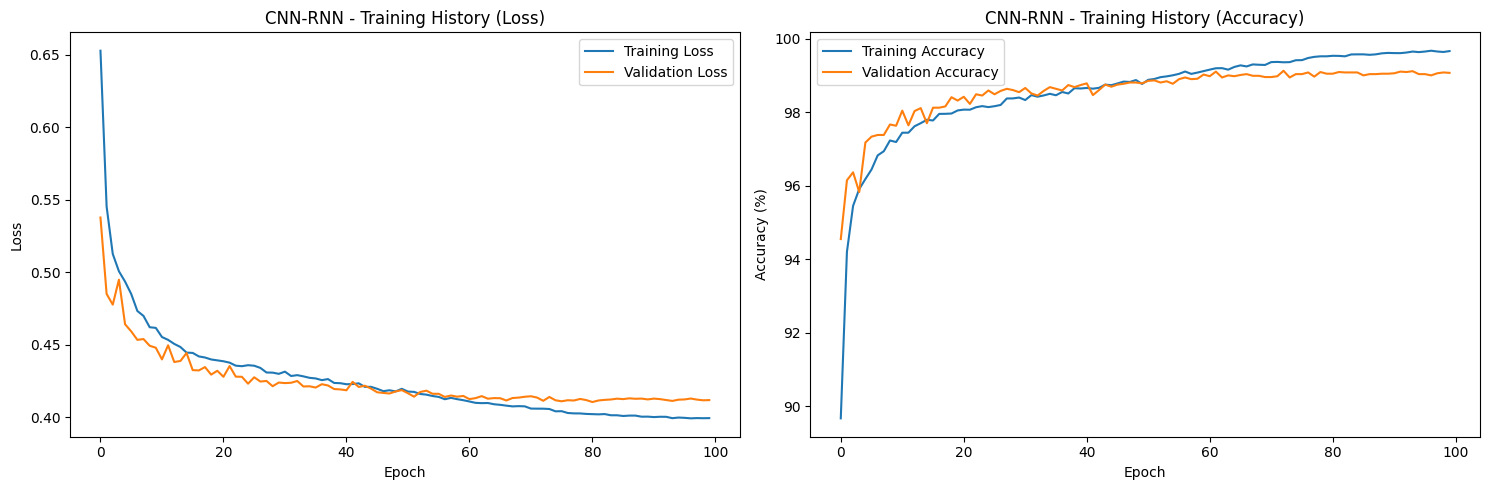

Testing: 100%|██████████| 343/343 [00:01<00:00, 183.76it/s]



Classification Report (CNN-RNN):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18118
           1       0.91      0.86      0.88       556
           2       0.97      0.97      0.97      1448
           3       0.90      0.84      0.87       162
           4       1.00      0.99      1.00      1608

    accuracy                           0.99     21892
   macro avg       0.95      0.93      0.94     21892
weighted avg       0.99      0.99      0.99     21892



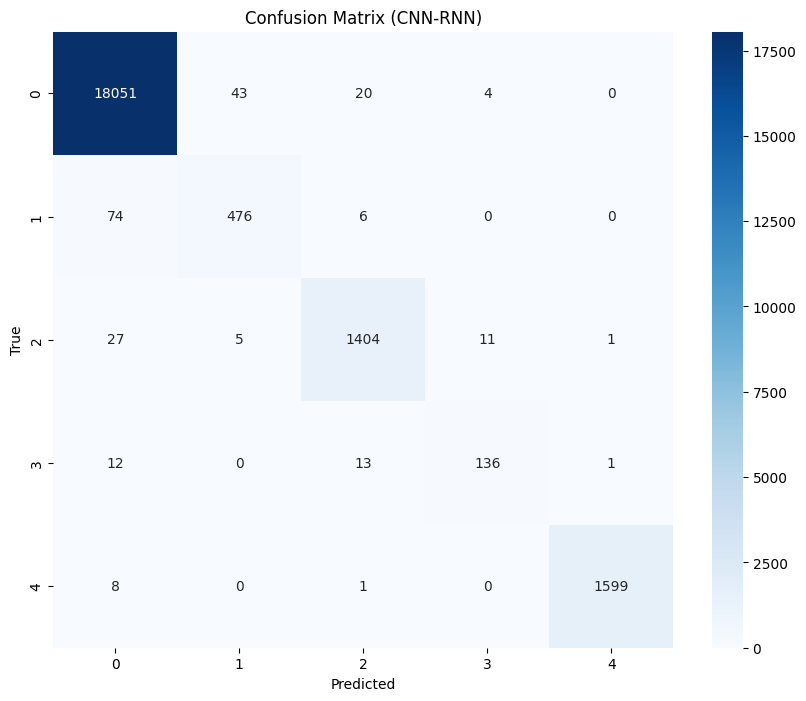

In [20]:
# Train models
rnn_trainer = train_rnn_model(X_train, X_val, X_test, y_train, y_val, y_test)

In [25]:
def get_test_accuracy(model, test_loader, device, model_name=''):
    model.eval()
    correct = 0
    total = 0
    
    print(f"\nEvaluating {model_name} model...")
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            # Handle different model outputs robustly (model may return logits or (logits, extra))
            result = model(batch_X)
            outputs = result[0] if isinstance(result, (tuple, list)) else result
            
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    accuracy = 100 * correct / total
    print(f"{model_name} Test Accuracy: {accuracy:.2f}%")
    return accuracy


In [ ]:
# Create test loader
test_dataset = ECGDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get accuracies
rnn_accuracy = get_test_accuracy(rnn_trainer.model, test_loader, device, "RNN")

print("\nSummary:")
print(f"RNN Test Accuracy: {rnn_accuracy:.2f}%")


Evaluating RNN model...
RNN Test Accuracy: 98.97%

Summary:
RNN Test Accuracy: 98.97%


In [ ]:
class AttentionRNN(nn.Module):
    """
    AttentionRNN
    ------------
    Compact sequence classifier that demonstrates the core building blocks used
    in the larger ECG_CNN_RNN architecture.

    Components:
    - Bidirectional GRU: encodes sequence into per-timestep hidden vectors.
    - Attention scorer: a small MLP that produces a scalar score per timestep.
    - Skip connection: projects raw inputs into the GRU hidden space and adds
      them to the GRU outputs to preserve low-level information.
    - Classification head: projects the attention-weighted context to logits.

    Input shapes:
    - x: (batch, seq_len, input_size)
    - Returns: (logits, attention_weights) where attention_weights is (batch, seq_len, 1)
    """
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.2):
        super(AttentionRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Bidirectional GRU produces hidden vectors of size hidden_size * 2
        self.gru = nn.GRU(input_size, hidden_size, num_layers, 
                          batch_first=True, bidirectional=True, dropout=dropout)
        
        # Attention scorer: maps per-timestep hidden vector -> scalar score
        self.attention = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
        
        # Skip connection: project raw input into the same dimensionality as GRU outputs
        self.skip_connection = nn.Linear(input_size, hidden_size * 2)
        
        # Small classification head
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # x: (batch, seq_len, input_size)
        gru_out, _ = self.gru(x)  # gru_out: (batch, seq_len, 2*hidden_size)
        
        # Project inputs and add as a residual (preserve low-level features)
        skip = self.skip_connection(x)  # (batch, seq_len, 2*hidden_size)
        gru_out = gru_out + skip
        
        # Compute attention weights over timesteps
        attention_weights = self.attention(gru_out)          # (batch, seq_len, 1)
        attention_weights = torch.softmax(attention_weights, dim=1)
        
        # Weighted sum to get context vector
        context = torch.sum(attention_weights * gru_out, dim=1)  # (batch, 2*hidden_size)
        
        # Classification MLP
        out = self.fc1(context)               # (batch, hidden_size)
        out = self.batch_norm(out)
        out = torch.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)                   # (batch, num_classes)
        
        return out, attention_weights

Using device: cuda
Starting training...


Epoch 1/100: 100%|██████████| 2463/2463 [00:13<00:00, 184.35it/s]


Epoch [1/100]
Train Loss: 0.2557, Val Loss: 0.1363
Validation Accuracy: 96.29%


Epoch 2/100: 100%|██████████| 2463/2463 [00:12<00:00, 203.15it/s]


Epoch [2/100]
Train Loss: 0.1298, Val Loss: 0.1094
Validation Accuracy: 97.14%


Epoch 3/100: 100%|██████████| 2463/2463 [00:11<00:00, 211.97it/s]


Epoch [3/100]
Train Loss: 0.1020, Val Loss: 0.0734
Validation Accuracy: 97.88%


Epoch 4/100: 100%|██████████| 2463/2463 [00:11<00:00, 212.34it/s]


Epoch [4/100]
Train Loss: 0.0851, Val Loss: 0.0605
Validation Accuracy: 98.25%


Epoch 5/100: 100%|██████████| 2463/2463 [00:11<00:00, 212.10it/s]


Epoch [5/100]
Train Loss: 0.0745, Val Loss: 0.0581
Validation Accuracy: 98.22%


Epoch 6/100: 100%|██████████| 2463/2463 [00:11<00:00, 212.45it/s]


Epoch [6/100]
Train Loss: 0.0673, Val Loss: 0.0521
Validation Accuracy: 98.41%


Epoch 7/100: 100%|██████████| 2463/2463 [00:11<00:00, 211.93it/s]


Epoch [7/100]
Train Loss: 0.0603, Val Loss: 0.0545
Validation Accuracy: 98.44%


Epoch 8/100: 100%|██████████| 2463/2463 [00:11<00:00, 212.03it/s]


Epoch [8/100]
Train Loss: 0.0569, Val Loss: 0.0505
Validation Accuracy: 98.55%


Epoch 9/100: 100%|██████████| 2463/2463 [00:11<00:00, 212.12it/s]


Epoch [9/100]
Train Loss: 0.0535, Val Loss: 0.0492
Validation Accuracy: 98.62%


Epoch 10/100: 100%|██████████| 2463/2463 [00:11<00:00, 213.22it/s]


Epoch [10/100]
Train Loss: 0.0483, Val Loss: 0.0414
Validation Accuracy: 98.82%


Epoch 11/100: 100%|██████████| 2463/2463 [00:11<00:00, 211.91it/s]


Epoch [11/100]
Train Loss: 0.0478, Val Loss: 0.0442
Validation Accuracy: 98.66%


Epoch 12/100: 100%|██████████| 2463/2463 [00:11<00:00, 212.09it/s]


Epoch [12/100]
Train Loss: 0.0453, Val Loss: 0.0444
Validation Accuracy: 98.63%


Epoch 13/100: 100%|██████████| 2463/2463 [00:11<00:00, 210.16it/s]


Epoch [13/100]
Train Loss: 0.0438, Val Loss: 0.0391
Validation Accuracy: 98.80%


Epoch 14/100: 100%|██████████| 2463/2463 [00:11<00:00, 211.85it/s]


Epoch [14/100]
Train Loss: 0.0421, Val Loss: 0.0421
Validation Accuracy: 98.85%


Epoch 15/100: 100%|██████████| 2463/2463 [00:11<00:00, 210.56it/s]


Epoch [15/100]
Train Loss: 0.0406, Val Loss: 0.0421
Validation Accuracy: 98.79%


Epoch 16/100: 100%|██████████| 2463/2463 [00:11<00:00, 213.81it/s]


Epoch [16/100]
Train Loss: 0.0398, Val Loss: 0.0384
Validation Accuracy: 98.80%


Epoch 17/100: 100%|██████████| 2463/2463 [00:11<00:00, 216.55it/s]


Epoch [17/100]
Train Loss: 0.0385, Val Loss: 0.0349
Validation Accuracy: 98.87%


Epoch 18/100: 100%|██████████| 2463/2463 [00:11<00:00, 213.00it/s]


Epoch [18/100]
Train Loss: 0.0366, Val Loss: 0.0461
Validation Accuracy: 98.72%


Epoch 19/100: 100%|██████████| 2463/2463 [00:11<00:00, 211.38it/s]


Epoch [19/100]
Train Loss: 0.0374, Val Loss: 0.0401
Validation Accuracy: 98.85%


Epoch 20/100: 100%|██████████| 2463/2463 [00:11<00:00, 215.25it/s]


Epoch [20/100]
Train Loss: 0.0352, Val Loss: 0.0408
Validation Accuracy: 98.82%


Epoch 21/100: 100%|██████████| 2463/2463 [00:11<00:00, 210.16it/s]


Epoch [21/100]
Train Loss: 0.0333, Val Loss: 0.0429
Validation Accuracy: 98.82%


Epoch 22/100: 100%|██████████| 2463/2463 [00:11<00:00, 212.19it/s]


Epoch [22/100]
Train Loss: 0.0248, Val Loss: 0.0317
Validation Accuracy: 99.13%


Epoch 23/100: 100%|██████████| 2463/2463 [00:11<00:00, 214.29it/s]


Epoch [23/100]
Train Loss: 0.0214, Val Loss: 0.0342
Validation Accuracy: 99.13%


Epoch 24/100: 100%|██████████| 2463/2463 [00:11<00:00, 214.19it/s]


Epoch [24/100]
Train Loss: 0.0213, Val Loss: 0.0322
Validation Accuracy: 99.03%


Epoch 25/100: 100%|██████████| 2463/2463 [00:11<00:00, 211.62it/s]


Epoch [25/100]
Train Loss: 0.0201, Val Loss: 0.0351
Validation Accuracy: 99.09%


Epoch 26/100: 100%|██████████| 2463/2463 [00:11<00:00, 212.28it/s]


Epoch [26/100]
Train Loss: 0.0189, Val Loss: 0.0381
Validation Accuracy: 99.04%


Epoch 27/100: 100%|██████████| 2463/2463 [00:11<00:00, 211.38it/s]


Epoch [27/100]
Train Loss: 0.0146, Val Loss: 0.0326
Validation Accuracy: 99.14%
Early stopping triggered after 27 epochs


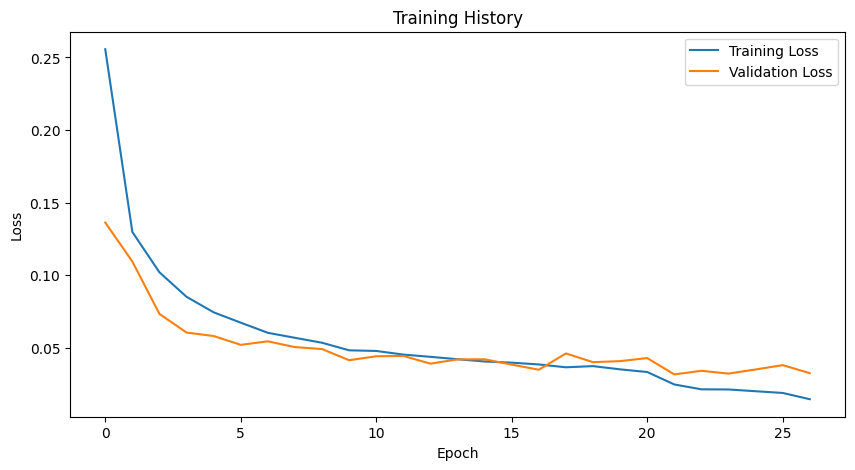

Testing: 100%|██████████| 685/685 [00:01<00:00, 569.56it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     18118
           1       0.94      0.83      0.88       556
           2       0.97      0.97      0.97      1448
           3       0.91      0.80      0.85       162
           4       1.00      0.99      1.00      1608

    accuracy                           0.99     21892
   macro avg       0.96      0.92      0.94     21892
weighted avg       0.99      0.99      0.99     21892



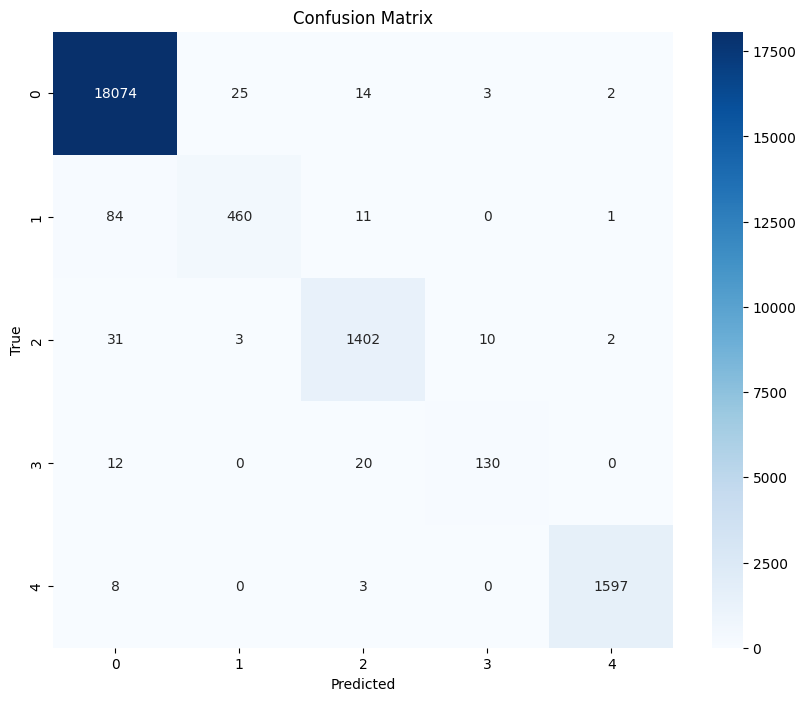

In [33]:
def train_and_evaluate():
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Create data loaders
    train_loader, val_loader, test_loader = create_data_loaders(
        X_train, X_val, X_test, y_train, y_val, y_test, batch_size=32
    )
    
    # Initialize model
    input_size = 1  # Single channel ECG
    hidden_size = 128
    num_layers = 2
    num_classes = len(np.unique(y_train))
    
    model = AttentionRNN(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        num_classes=num_classes
    ).to(device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    # Train the model
    num_epochs = 100
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    patience = 5
    patience_counter = 0
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    
    print("Starting training...")
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        
        for batch_X, batch_y in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs, _ = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_train_loss += loss.item()
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs, _ = model(batch_X)
                loss = criterion(outputs, batch_y)
                total_val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
        
        # Calculate average losses and accuracy
        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # Step the scheduler
        scheduler.step(avg_val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.2f}%')
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Evaluate on test set
    model.eval()
    test_predictions = []
    test_labels = []
    
    with torch.no_grad():
        for batch_X, batch_y in tqdm(test_loader, desc='Testing'):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs, _ = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            
            test_predictions.extend(predicted.cpu().numpy())
            test_labels.extend(batch_y.cpu().numpy())
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(test_labels, test_predictions))
    
    # Plot confusion matrix
    cm = confusion_matrix(test_labels, test_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Save the final model
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
    }, 'ecg_model_final.pth')

if __name__ == "__main__":
    train_and_evaluate()

In [34]:
# Initialize model
input_size = 1  # Single channel ECG
hidden_size = 128
num_layers = 2
num_classes = 5  

# Create model instance
model = AttentionRNN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_classes=num_classes
).to(device)

# Create test loader if not already created
test_dataset = ECGDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32)

# Load the saved model weights
try:
    checkpoint = torch.load('ecg_model_final.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Make sure the model file 'ecg_model_final.pth' exists in the current directory")

Model loaded successfully!


In [35]:
def get_attention_rnn_accuracy(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    print("\nEvaluating AttentionRNN model...")
    
    with torch.no_grad():
        for batch_X, batch_y in tqdm(test_loader, desc='Testing'):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs, _ = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    accuracy = 100 * correct / total
    
    # Print results
    print(f"\nTest Results:")
    print(f"Total samples: {total}")
    print(f"Correct predictions: {correct}")
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    return accuracy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_accuracy = get_attention_rnn_accuracy(model, test_loader, device)


Evaluating AttentionRNN model...


Testing: 100%|██████████| 685/685 [00:01<00:00, 545.60it/s]


Test Results:
Total samples: 21892
Correct predictions: 21663
Test Accuracy: 98.95%



Evaluating AttentionRNN model...


Testing: 100%|██████████| 685/685 [00:01<00:00, 527.03it/s]



Test Results:
Total samples: 21892
Correct predictions: 21663
Test Accuracy: 98.95%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     18118
           1       0.94      0.83      0.88       556
           2       0.97      0.97      0.97      1448
           3       0.91      0.80      0.85       162
           4       1.00      0.99      1.00      1608

    accuracy                           0.99     21892
   macro avg       0.96      0.92      0.94     21892
weighted avg       0.99      0.99      0.99     21892



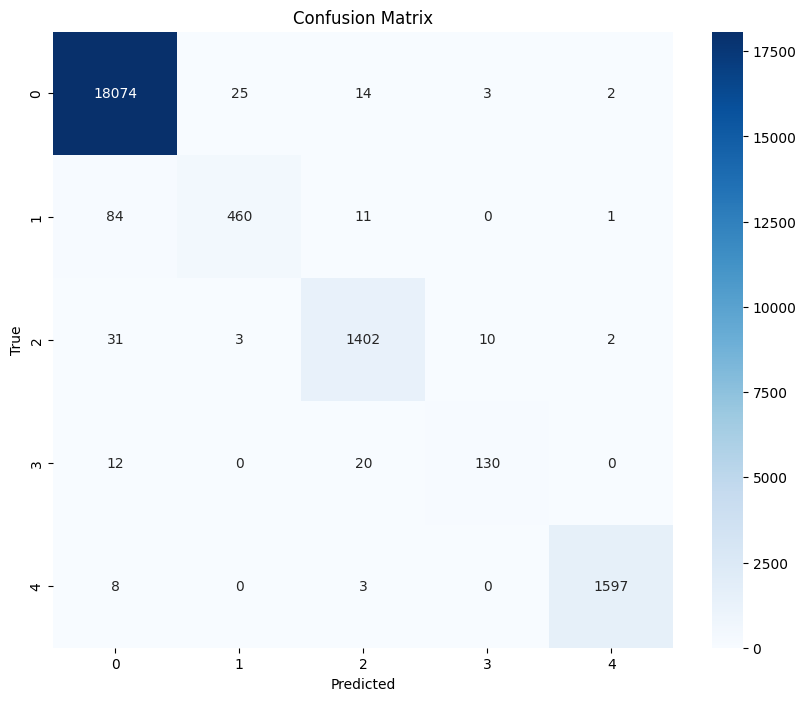

In [36]:
def evaluate_attention_rnn(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    correct = 0
    total = 0
    
    print("\nEvaluating AttentionRNN model...")
    
    with torch.no_grad():
        for batch_X, batch_y in tqdm(test_loader, desc='Testing'):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs, _ = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    
    accuracy = 100 * correct / total
    
    # Print results
    print(f"\nTest Results:")
    print(f"Total samples: {total}")
    print(f"Correct predictions: {correct}")
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions))
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    return accuracy

test_accuracy = evaluate_attention_rnn(model, test_loader, device)

# DATA AUGMENTATION PORTION

## data augmentation: using stratified split instead to maintain class distribution

In [ ]:
class ECGDataProcessor:
    """
    Class to handle ECG data preprocessing for multiple datasets
    """
    def __init__(self, mitbih_train_path, mitbih_test_path, incart_path):
        self.mitbih_train_path = mitbih_train_path
        self.mitbih_test_path = mitbih_test_path
        self.incart_path = incart_path
        self.scaler = StandardScaler()

    def load_and_preprocess_mitbih(self):
        """
        Load and preprocess MIT-BIH test dataset
        """
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        return X_train, y_train,X_test, y_test

    def _print_class_distribution(self, dataset_name, y):
        """
        Print class distribution for a dataset
        """
        print(f"\nClass distribution in {dataset_name} dataset:")
        classes = np.unique(y)
        for class_id in classes:
            count = np.sum(y == class_id)
            percentage = (count / len(y)) * 100
            print(f"Class {class_id}: {count} samples ({percentage:.2f}%)")

    def preprocess_mitbih_data(self):
        """
        Load and preprocess MIT-BIH test dataset
        """
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train,
            test_size=0.1,
            random_state=42,
            stratify=y_train # added stratify to our split to keep class distribution
        )

        # Reshape for RNN input (batch_size, sequence_length, input_size)
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        return X_train, X_val, X_test, y_train, y_val, y_test

## data augmentation: additive noise + crop

In [21]:
import numpy as np

def additive_noise(dataset, noise_min= 0.000, noise_max= 0.0369, add_gaussian= True, add_jitter= True):
    noise_lvl = np.random.uniform(noise_min, noise_max)
    noisy_dataset = dataset.copy()

    if add_gaussian:
        gaussian_noise = np.random.normal(loc= 0.0, scale= noise_lvl, size= dataset.shape)
        noisy_dataset += gaussian_noise
    if add_jitter:
        jitter_noise = np.random.uniform(-noise_lvl/2, noise_lvl/2, size=dataset.shape)
        noisy_dataset += jitter_noise

    return dataset

In [22]:
def crop_dataset(dataset, start_index= None):
    dataset_size = dataset.shape[0]

    if not start_index:
        start_index = 0
    
    crop_size = np.random.randint(0, dataset_size)
    start_index = np.random.randint(0, dataset_size - crop_size + 1)

    end_index = start_index + crop_size
    cropped_dataset = dataset[start_index:end_index]

    final_dataset = np.resize(cropped_dataset, dataset.shape)

    return final_dataset

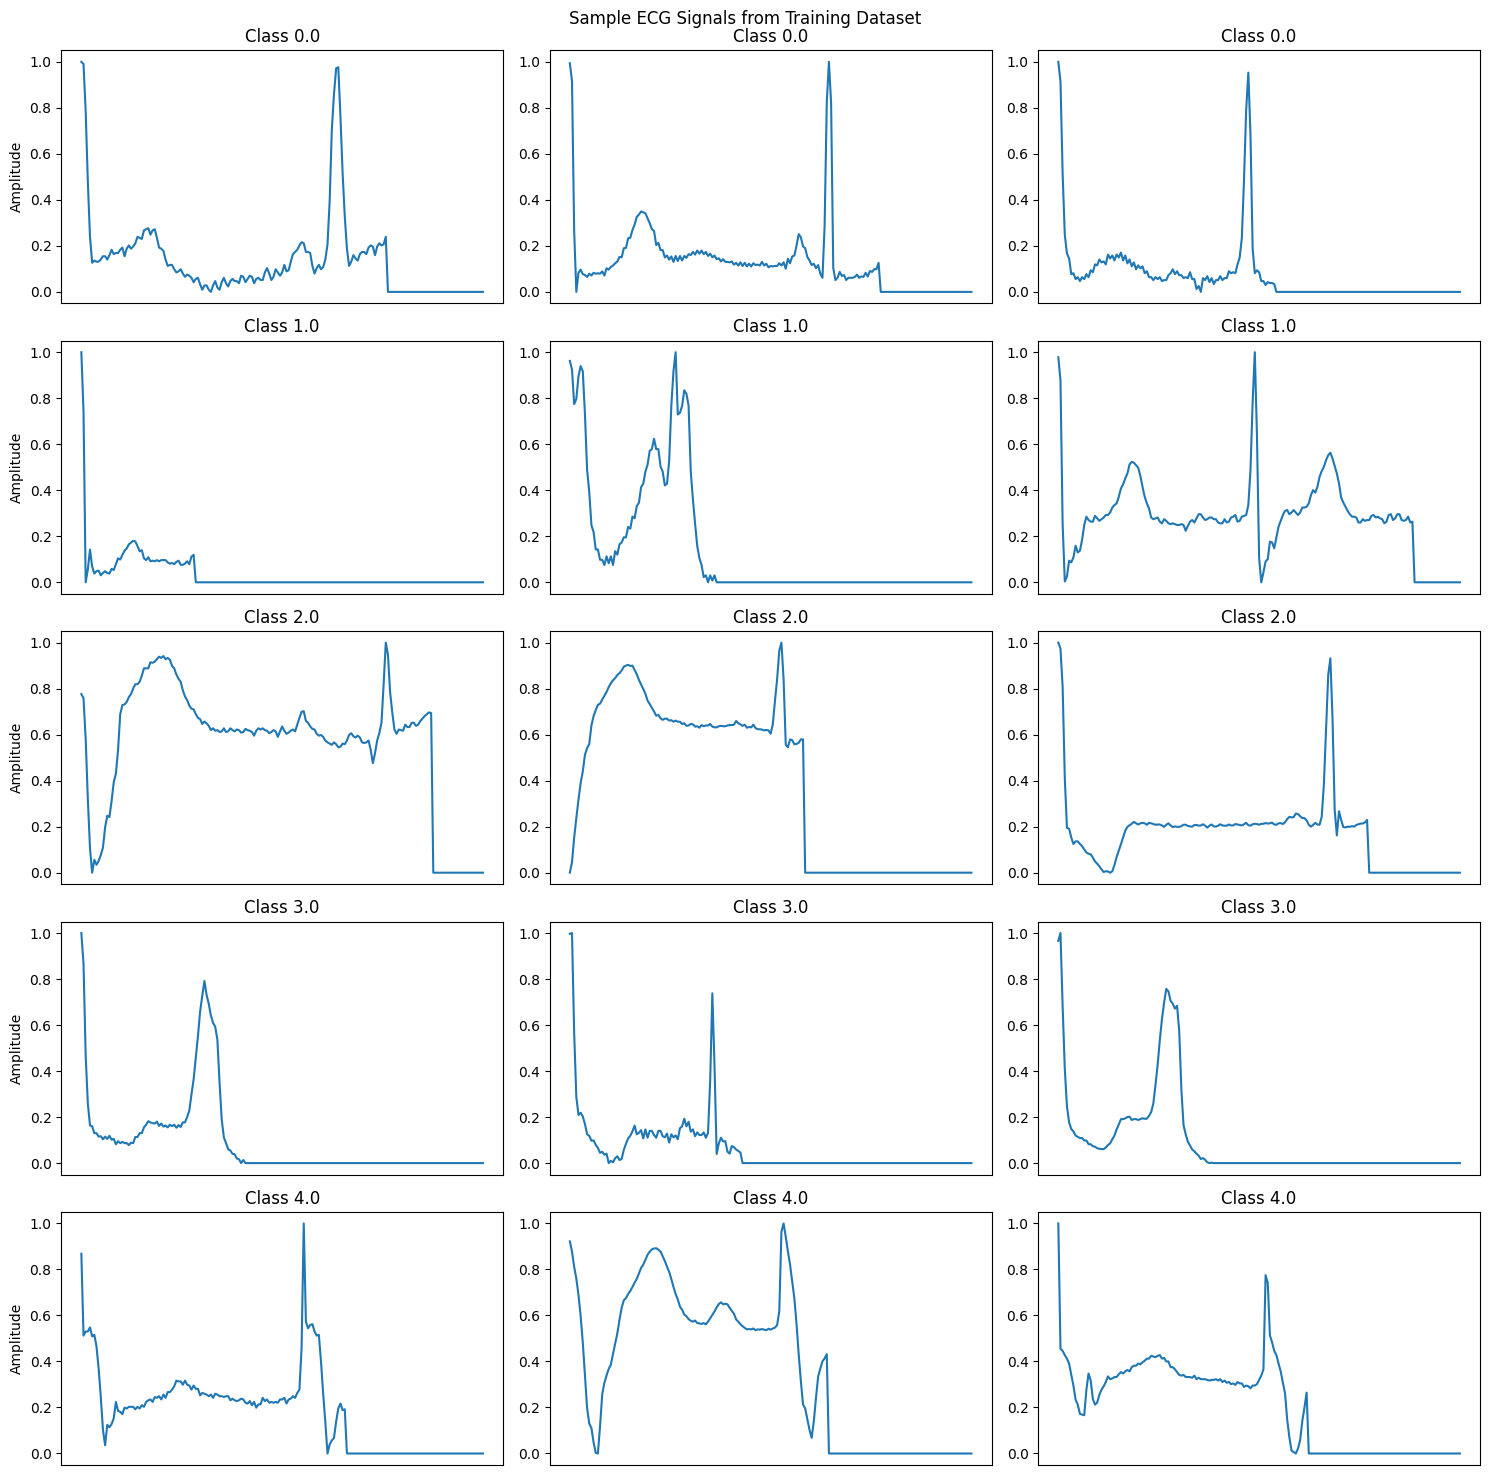

In [23]:
exp0 = additive_noise(X_train)

plot_sample_signals(exp0, y_train, "Training")

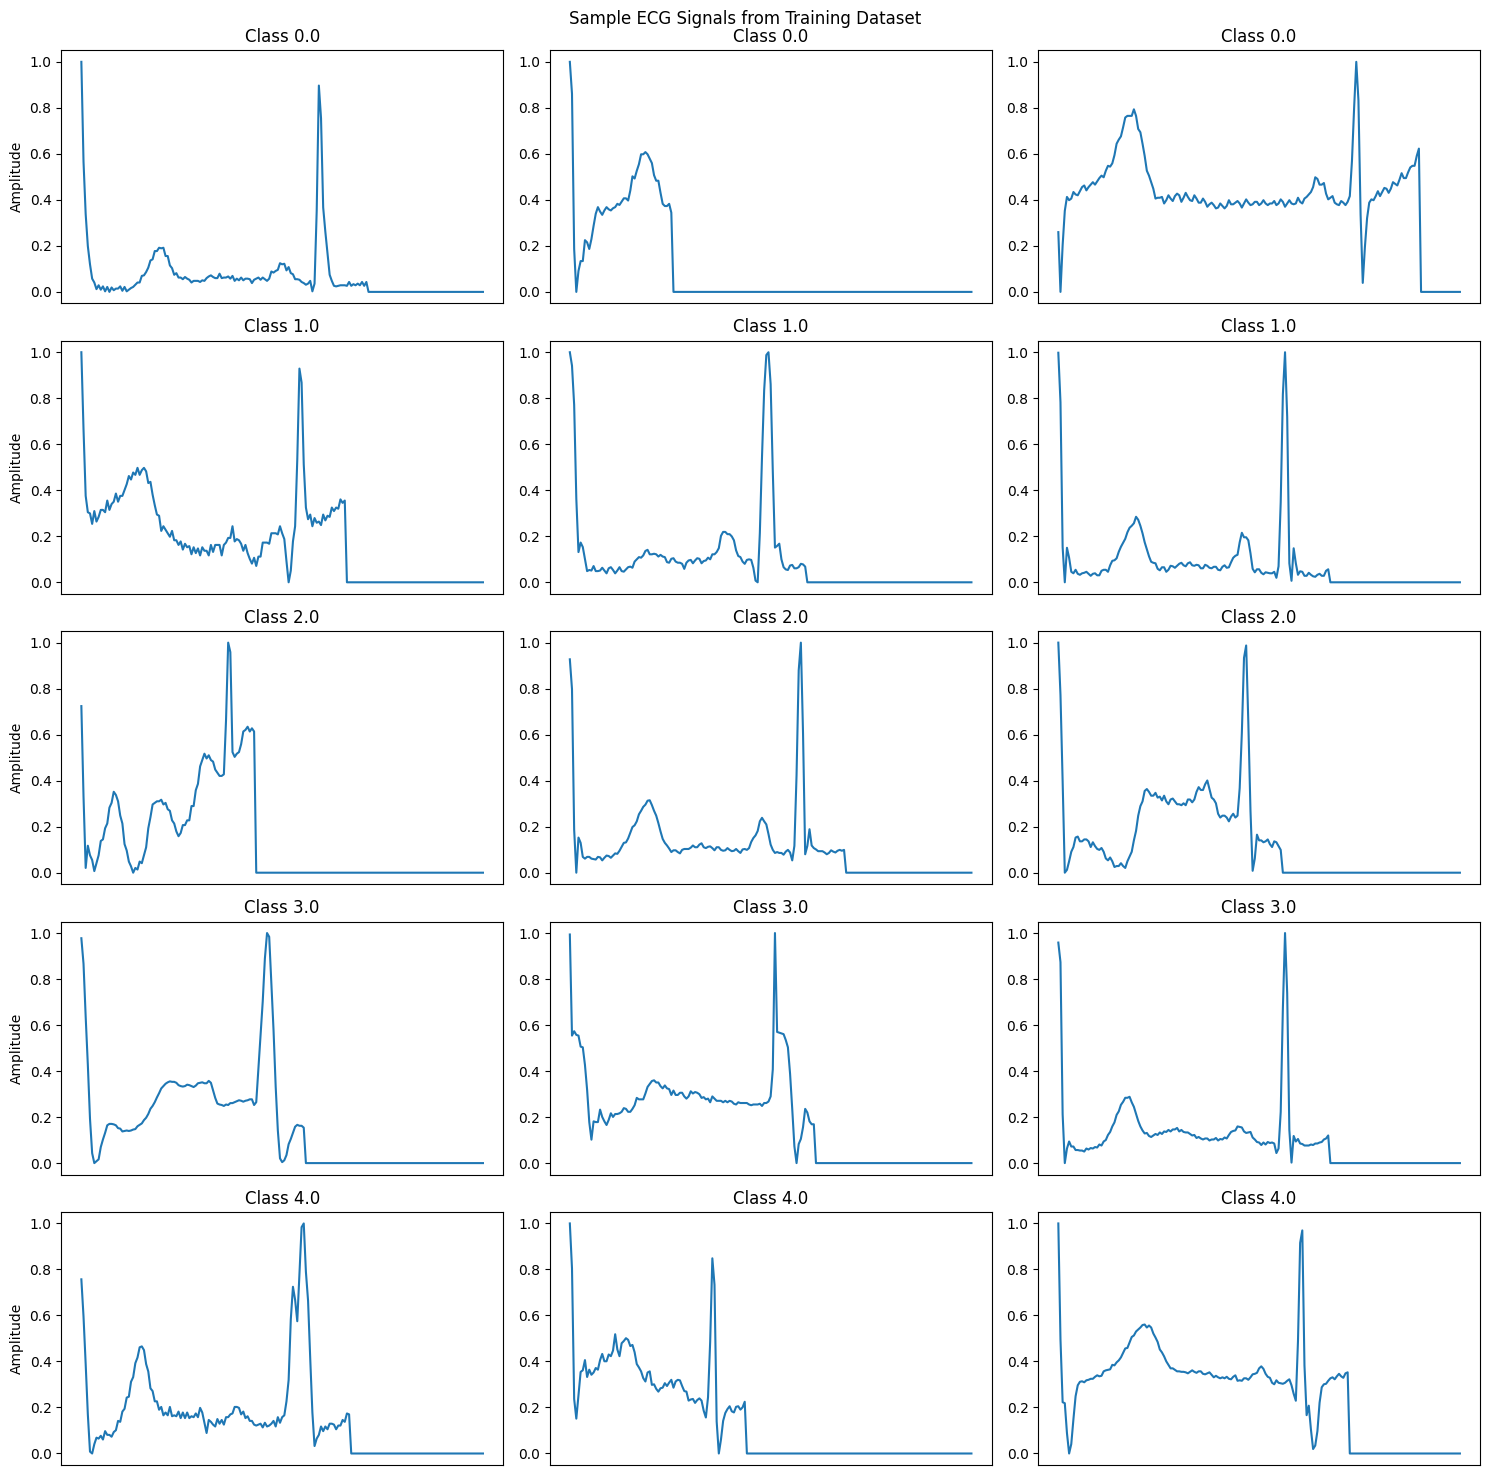

In [24]:
exp1 = crop_dataset(X_train)

plot_sample_signals(exp1, y_train, "Training")